In [41]:
"""
Importing all the basic libraries
"""

import os 
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [42]:
"""
Importing all the sklearn models 
"""

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, roc_auc_score, plot_confusion_matrix,
                             precision_recall_curve, roc_curve)

In [43]:
"""
Importing the torch modules 
"""

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

In [44]:
warnings.filterwarnings("ignore")
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [45]:
data = pd.read_csv('new_physics_signal.csv')
data.head(3)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,Class
0,78.482022,52.871985,-64.917465,-78.448475,-57.987246,-92.520585,27.806597,46.774201,-57.512910,22.899098,-38.790567,-83.959697,11.666977,846.710033,0
1,78.379086,55.058180,-68.153619,-82.693368,-59.561586,-93.335494,19.354007,47.128549,-60.470478,23.100267,-36.209469,-84.888323,11.836796,25.025335,0
2,79.609922,55.395154,-61.506139,-99.031856,-56.643424,-91.474574,32.361097,48.480810,-63.011139,20.523559,-38.380731,-85.190411,11.483291,2127.582986,0


In [46]:
data = data.dropna()
shuffled = data.sample(frac=1, random_state=4)
data_zero = shuffled.loc[shuffled['Class'] == 0].sample(n=800, random_state = 123)
data_one = shuffled.loc[shuffled['Class'] == 1]

data_sampled_concated = pd.concat([data_zero, data_one]).sample(frac=1, random_state=4)
data_sampled_concated = data_sampled_concated.reset_index(drop=True)
data = data_sampled_concated

x_data = data.loc[:, data.columns[:-1]]
y_data = data.loc[:, data.columns[-1:]]

In [47]:
# not scaling the data for now.

scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)

In [48]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [49]:
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

In [50]:
x_loader = DataLoader(x_tensor, batch_size = 64)
y_loader = DataLoader(y_tensor, batch_size = 64)

## Varional Autoencoder

In [51]:
class Encoder(nn.Module):
    def __init__(self, in_features, hidden_features, latent_features):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(in_features, hidden_features)
        self.linear2 = nn.Linear(hidden_features, latent_features)
        self.linear3 = nn.Linear(hidden_features, latent_features)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.KL = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.KL = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_features, out_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_features, out_features)
    
    def forward(self, z):
        z = self.linear1(z)
        return z

In [52]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_features, hidden_features, latent_features):
        super(VariationalEncoder, self).__init__()
        self.encoder = Encoder(in_features, hidden_features, latent_features).to(device)
        self.decoder = Decoder(latent_features, in_features).to(device)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [53]:
def train(model, x_loader, y_loader, optimizer, epochs):
    LOSS = []
    for epoch in tqdm(range(epochs), total = epochs):
        running_loss = 0.0
        for x, _ in zip(x_loader, y_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = model(x)
            loss = ((x - x_hat)**2).mean() + model.encoder.KL
            running_loss += loss
            loss.backward()
            LOSS.append(loss.item())
            optimizer.step()
        print(f"LOSS after {epoch} is: {running_loss / len(x_loader.dataset)}")
    return model, LOSS

In [54]:
def plot_latent_representation(model, x_loader, y_loader, num_batches = 10):
    for i, (x, y) in enumerate(zip(x_loader, y_loader)):
        z = model.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [55]:
model = VariationalEncoder(14, 4, 2).to(device)
model

VariationalEncoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=14, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=2, bias=True)
    (linear3): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=14, bias=True)
  )
)

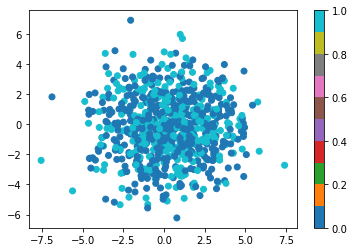

In [56]:
plot_latent_representation(model, x_loader, y_loader)

In [57]:
optimizer = torch.optim.RMSprop(model.parameters())
model, LOSS = train(model, x_loader, y_loader, optimizer, epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

LOSS after 0 is: 1.7809946537017822
LOSS after 1 is: 0.8972308039665222
LOSS after 2 is: 0.7603480815887451
LOSS after 3 is: 0.7165548801422119
LOSS after 4 is: 0.7011929154396057
LOSS after 5 is: 0.6958141326904297
LOSS after 6 is: 0.6940258741378784
LOSS after 7 is: 0.6934800744056702
LOSS after 8 is: 0.693331241607666
LOSS after 9 is: 0.6932960748672485
LOSS after 10 is: 0.6932888031005859
LOSS after 11 is: 0.6932875514030457
LOSS after 12 is: 0.6932875514030457
LOSS after 13 is: 0.6932874917984009
LOSS after 14 is: 0.6932875514030457
LOSS after 15 is: 0.69328773021698
LOSS after 16 is: 0.6932879090309143
LOSS after 17 is: 0.6932879090309143
LOSS after 18 is: 0.6932879090309143
LOSS after 19 is: 0.6932880878448486
LOSS after 20 is: 0.6932883262634277
LOSS after 21 is: 0.6932882070541382
LOSS after 22 is: 0.693288266658783
LOSS after 23 is: 0.6933891773223877
LOSS after 24 is: 0.6932900547981262
LOSS after 25 is: 0.6933888792991638
LOSS after 26 is: 0.6932961940765381
LOSS after 27 i

Text(0.5, 1.0, 'Loss curve')

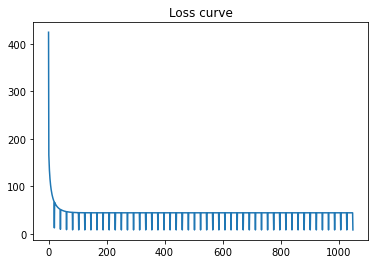

In [58]:
plt.plot(LOSS)
plt.title('Loss curve')

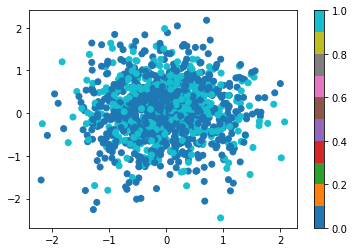

In [59]:
plot_latent_representation(model, x_loader, y_loader, num_batches=16)

### T-SNE visualization

In [60]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=3)
pca_res = pca.fit_transform(x_data)

In [62]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21900176 0.15901509 0.12298119]


In [63]:
data_final = pd.concat([pd.DataFrame(x_data), pd.DataFrame(y_data)], axis=1)
columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'y']

data_final.columns = columns

In [64]:
data_final['pca-one'] = pca_res[:,0]
data_final['pca-two'] = pca_res[:,1] 
data_final['pca-three'] = pca_res[:,2]

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

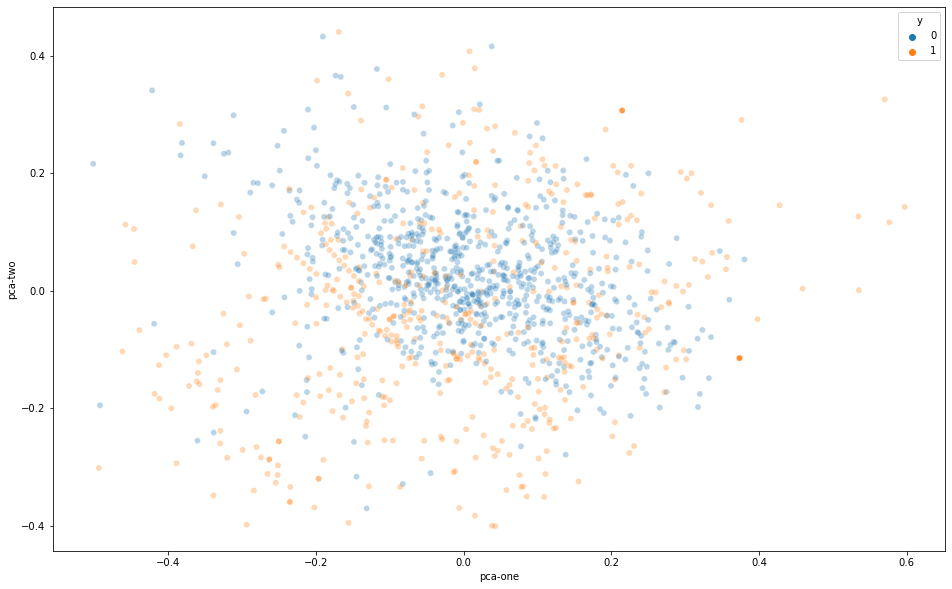

In [65]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    data=data_final,
    legend="full",
    alpha=0.3
)

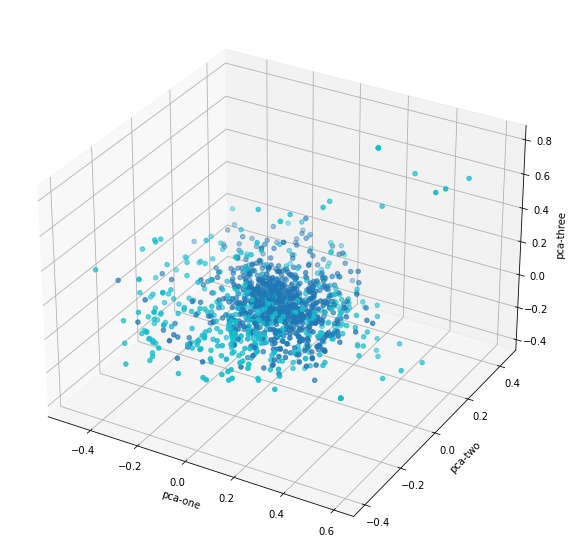

In [69]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=data_final["pca-one"], 
    ys=data_final["pca-two"], 
    zs=data_final["pca-three"], 
    c=data_final["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [70]:
import plotly.graph_objects as go

In [71]:
fig = go.Figure(data=[go.Scatter3d(x=data_final["pca-one"], 
                                   y=data_final["pca-two"], 
                                   z=data_final["pca-three"],
                                   
                                   marker=dict(
                                        size=3,
                                        color=data_final['y'],                
                                        colorscale='Viridis', 
                                        opacity=0.8),
                                   mode='markers')])
fig.show()

In [72]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_final)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.000s...
[t-SNE] Computed neighbors for 1292 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.127323
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.850807
[t-SNE] KL divergence after 300 iterations: 1.247270
t-SNE done! Time elapsed: 1.6913583278656006 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

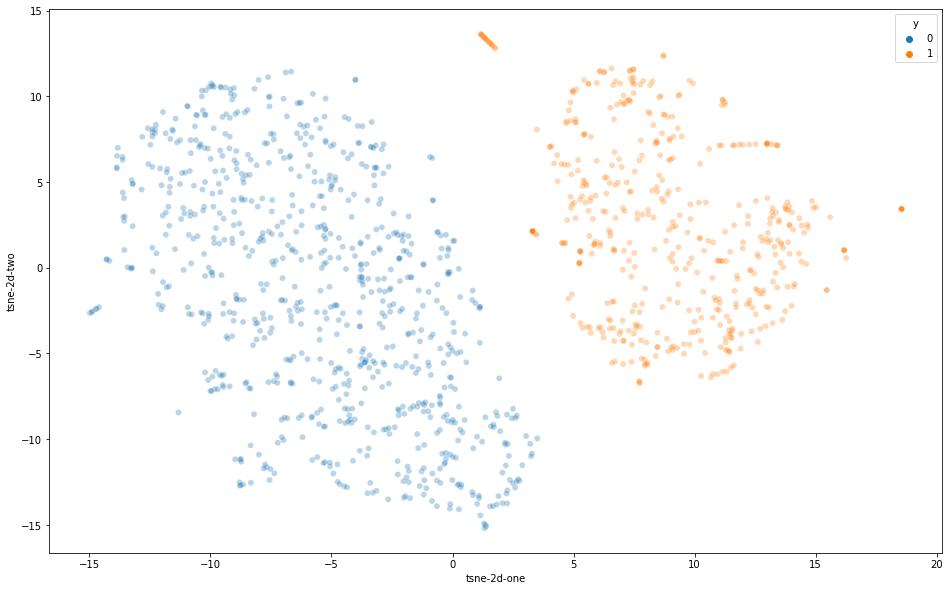

In [73]:
data_final['tsne-2d-one'] = tsne_results[:,0]
data_final['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=data_final,
    legend="full",
    alpha=0.3
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

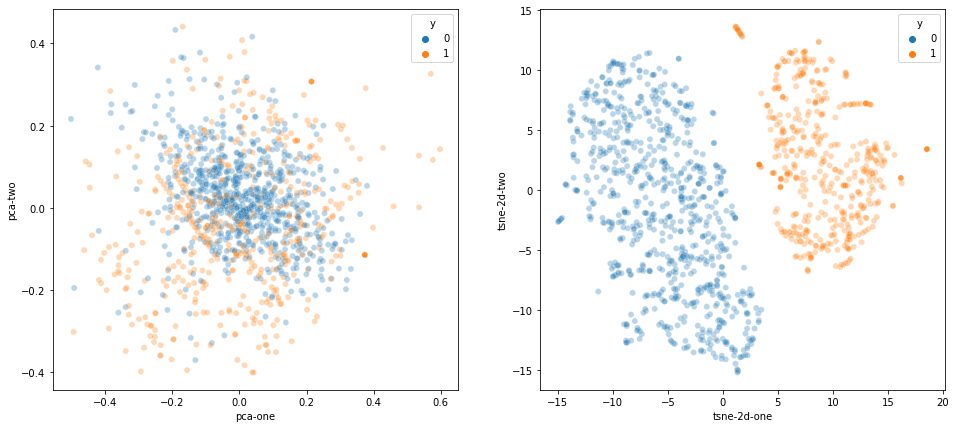

In [74]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    data=data_final,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=data_final,
    legend="full",
    alpha=0.3,
    ax=ax2
)

### Reconstruction from Randnom

In [75]:
def generate(model, r0=(-5, 10), r1=(-10, 5), n=100):
    w = 14
    noise = np.random.rand(n, w)
    
    z = torch.Tensor(noise).to(device)
    x_hat = model(z)
    x_hat = x_hat.detach().numpy().reshape(n, w)
    return x_hat

In [76]:
x_gen = generate(model)

In [77]:
data_recon = pd.DataFrame(x_gen)
y_recon = np.array([2] * 100)
data_recon['y'] = y_recon
data_recon.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'y']

In [78]:
data_final_tilly = data_final.iloc[:, :-5]

In [79]:
data_recon_merged = pd.concat([data_final_tilly, data_recon])

In [80]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_recon_merged)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1392 samples in 0.003s...
[t-SNE] Computed neighbors for 1392 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1392
[t-SNE] Computed conditional probabilities for sample 1392 / 1392
[t-SNE] Mean sigma: 0.096793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.415634
[t-SNE] KL divergence after 300 iterations: 1.294689
t-SNE done! Time elapsed: 1.5092582702636719 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

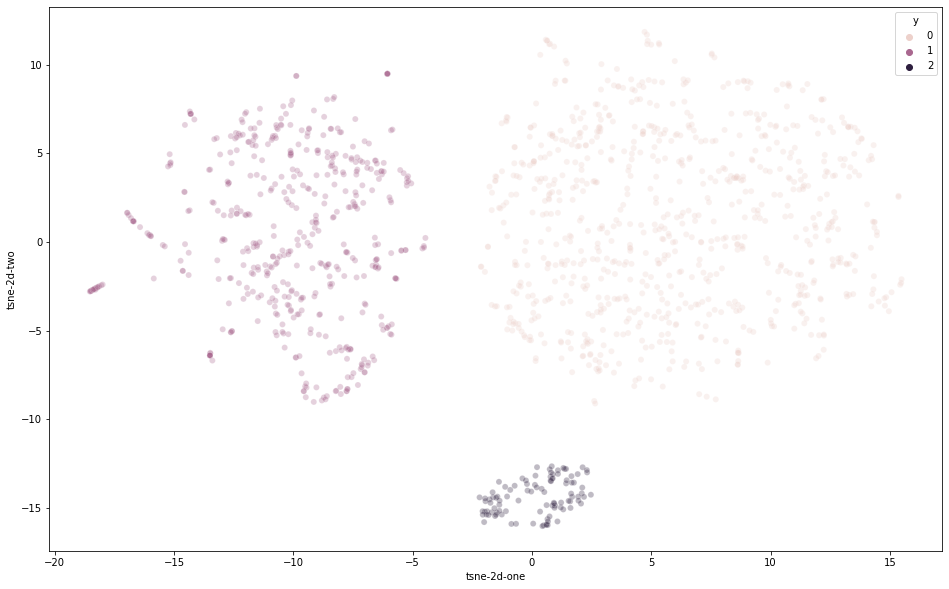

In [81]:
data_recon_merged['tsne-2d-one'] = tsne_results[:,0]
data_recon_merged['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=data_recon_merged,
    legend="full",
    alpha=0.3
)